# Notebook for testing data for pilot 3

Pilot 3 added more checks for engagement early in the experiment.
Iteration names:
'pre-pilot3':

## 1. Read in packages and set up server connection
This first section will read in necessary packages for anaysis and establish file paths and connections to the mongo db server

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

In [4]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [5]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['compositional-abstractions']
coll = db['two-towers']

# which iteration name should we use?
iterationName = 'pilot_class_test'

## look up number of trials (including paired-practice)
numTrials = 13

## 2. Construct tidy dataframe with game data

### establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

#### Pass in list of iterations, returns list of total games and completed games for each

In [6]:
## get list of all gameIDs in database
#iterationList = ['livetest0','pilot0','pilot2']

iterationList = [iterationName]

for iteration in iterationList:
    #get total games
    total_games = coll.find({'iterationName':iteration}).distinct('gameid')
    print('There are {} total games in iteration: {}.'.format(len(total_games), iteration))

    ## get list of complete gameIDs
    gameIDs = coll.find({'iterationName':iteration}).distinct('gameid')
    complete_games = [g for g in gameIDs if len(coll.find({'gameid':g}).distinct('trialNum')) == numTrials]
    print('There are {} complete games in iteration: {}.'.format(len(complete_games), iteration))

There are 26 total games in iteration: pilot_class_test.
There are 9 complete games in iteration: pilot_class_test.


## Test functions for incoming data

In [ ]:
#find bonus for a particular worker
pd.DataFrame(coll.find({'iterationName':iterationName, 'workerId': 'AZLRPIAD0ZHAA'})).gameid

In [ ]:
pd.DataFrame(coll.find({'iterationName':iterationName, 'gameid': '6769-a7507958-e051-413c-8e2e-c02a73f1bd61'})).cumulativeBonus

In [ ]:
# grab all data so far
a = pd.DataFrame(coll.find({'iterationName':iterationName}))
#a[(a.trialNum==3) & (a.eventType=='endTrial')]
a

In [ ]:
a = pd.DataFrame(coll.find({'iterationName':iterationName}))

nParticipants = {}

for i in range(0,12):
    nParticipants[str(i)] = a[(a.trialNum==i) & (a.eventType=='endTrial')].shape[0]
    
nParticipants

In [10]:
a = pd.DataFrame(coll.find({'iterationName':iterationName}))

nParticipants = {}

for i in range(0,12):
    nParticipants[str(i)] = a[(a.trialNum==i) & (a.eventType=='endTrial')].shape[0]
    
nParticipants

{'0': 18,
 '1': 18,
 '2': 18,
 '3': 15,
 '4': 14,
 '5': 14,
 '6': 12,
 '7': 11,
 '8': 10,
 '9': 10,
 '10': 9,
 '11': 9}

In [ ]:
a.columns

In [ ]:
# Number of unique workers in db for an iterationName
len((coll.find({'iterationName':iterationName})).distinct('workerId'))

In [ ]:
len((coll.find({'iterationName':iterationName})).distinct('gameid'))

### get data for different kinds of failure
Only includes *submitted* data

In [13]:
# find all people who failed on quiz
quiz_fails = a[a.failType=='instructionsQuiz']
quiz_fails

AttributeError: 'DataFrame' object has no attribute 'failType'

In [12]:
# find all people who failed on solo practice
solo_fails = a[a.failType=='soloPractice']
solo_fails

AttributeError: 'DataFrame' object has no attribute 'failType'

In [8]:
# find all people who failed on solo practice 
b = a[(a.eventType=='exitSurvey')]
paired_fails = b[b.pairedPracticeFails == 3]
paired_fails

NameError: name 'a' is not defined

In [9]:
# How many trials did each dyad complete?
c = a[(a.turnNum==0) & (a.eventType=='chatMessage') & (a.trialNum!='practice')]
num_trials_complete = c.groupby(['gameid']).count()

NameError: name 'a' is not defined

In [14]:
broken_games = []
complete_games = [g for g in complete_games if g not in broken_games]

def construct_tidy_dataframe(eventType = 'chatMessage', 
                             complete_games = [],
                             iterationName = 'pilot4b',
                             remove_workerID = True):
    '''
    input: list of complete games and name of event Type
    '''
    event2name = {'chatMessage':'chat', 'block':'block', 'endTrial':'trial', 'exitSurvey':'exit'}
    L = pd.DataFrame()
    for g, this_gameID in enumerate(complete_games):
        print('Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games)))
        clear_output(wait=True) 

        ### extract records 
        #loop over iteration names??
        X = coll.find({ '$and': [{'iterationName':iterationName}, 
#                                  {"$or":[{'iterationName':'Exp2Pilot3'},
#                                  {'iterationName':'Exp2Pilot3_batch2'}]}
                                 {'gameid': this_gameID}, {'eventType': eventType}]}).sort('time') 
        
        li = list(X)        
        _L = pd.DataFrame(li)  

        ## concat with previous game's dataframe
        if L.shape[0]==0:
            L = _L
        else: 
            L = pd.concat([L,_L], axis=0)     

    ## postprocessing
    if remove_workerID and 'workerId' in L.columns:
        L = L.drop('workerId',axis=1)
        
    if eventType in ['block','endTrial','chatMessage']:
        L['practice'] = L.trialNum == 'practice'
        L.trialNum = pd.to_numeric(L['trialNum'], errors='coerce')

    ## save out group dataframe to csv dir
    out_path = os.path.join(csv_dir,'compabs_{}_{}.csv'.format(event2name[eventType],iterationName))
    print('Saving dataframe out to CSV dir at path: {}'.format(out_path))    
    L.to_csv(out_path)             

    return L


In [15]:
## construct dataframe for each datatype
dataTypes = coll.distinct('eventType')
for thisDataType in dataTypes:
    X = construct_tidy_dataframe(eventType=thisDataType, complete_games=complete_games, iterationName=iterationName)


Saving dataframe out to CSV dir at path: /Users/will/compositional-abstractions/results/csv/compabs_exit_pilot_class_test.csv


## 3. Create a full DF from DB
We can read in a full df from the db and do some basic checks to make sure the data look right

#### check outcome for specific workerID
Must pass in gameid and corresponding iteration

In [ ]:
f = pd.DataFrame(coll.find({'iterationName': iterationName}))
f['gameid'].unique()

In [ ]:
#set worker ID
workerID = 'testsubject003'

#get GameID (not all info available at workerID level (e.g. bonus))
gameID = df_full[df_full['workerId'] == workerID]['gameid'].unique()[0]

#check iteration name
df_game = df_full[(df_full['iterationName'] == iterationName) &
                            (df_full['gameid'] == gameID)]
#get workerIds
print('workerIDS:',df_game['workerId'].unique())
#get bonus for gameID ([air of workerIDs])
print("Bonus:",np.nanmax(df_game['cumulativeBonus']))

In [ ]:
#see full history for single worker
df_test = df_full[(df_full['iterationName'] == iterationName)&
                           (df_full['workerId'] == workerID)]
df_test.content.unique()

## 4. Trial Level Data
We're going to construct a spearate df for each event type (chat, block, endTrial, Survey) which will make analysis a little easier.
We also want to be able to concatenate multiple iterations for grouped analysis of previous versions.

### Load data from CSVs

In [16]:
iterationName = 'pilot_class_test'

In [17]:
# Load csvs for this iterationName

event_types = ['block', 'chat','exit','trial']
iteration_list = [iterationName]
df_dict = {}
for event in event_types:
    event_dict = {}
    df_name = 'df_'+ event
    for iteration in iteration_list:
        df_temp = 'df_'+event+"_"+iteration # the name for the dataframe
        file_name = '../results/csv/compabs_{}_{}.csv'.format(event,iteration)
        event_dict[df_temp] = pd.read_csv(file_name)
    df_dict[df_name] = pd.concat(event_dict.values(), ignore_index = True)

In [18]:
# Save loaded CSVs locally 

df_dict['df_block'].to_csv('df_block.csv', header=True, index=False) 
df_dict['df_chat'].to_csv('df_chat.csv', header=True, index=False) 
df_dict['df_exit'].to_csv('df_exit.csv', header=True, index=False) 
df_dict['df_trial'].to_csv('df_trial.csv', header=True, index=False) 

#### Read in CSVs

In [19]:
#read in dataframes from each eventType
df_block = pd.read_csv('df_block.csv')
df_chat = pd.read_csv('df_chat.csv')
df_exit = pd.read_csv('df_exit.csv')
df_trial = pd.read_csv('df_trial.csv')

## 5. General Analysis
Now that we have our dfs constructed, we can do some basic analysis. If you prefer to analyze in R, there is a separate notebook in this directory that reads in the .csv files previously constructed. But if you're feeling particularly pythonic, carry on.

#### Exclusion Criteria

In [20]:
# How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 5


In [21]:
includedGames = list(df75.reset_index().gameid)

In [22]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

In [23]:
#df_exit2 = pd.read_csv('../results/csv/compabs_exit_pilot2.csv')
df_exit.confused.unique()

array(['yes', 'confused'], dtype=object)

In [24]:
df_exit.nativeEnglish.unique()

array(['yes', 'no'], dtype=object)

#### Total Game Duration (for Gameplay)

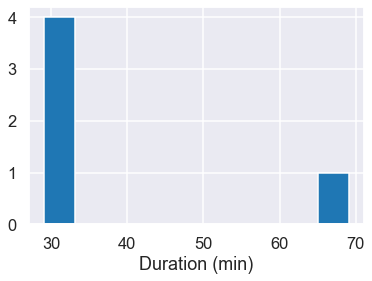

In [25]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

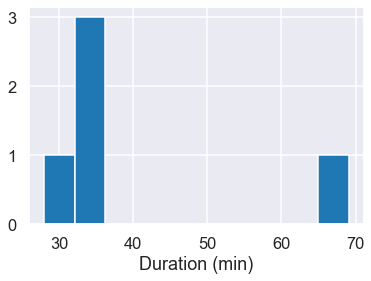

In [26]:
(df_exit.groupby(['gameid'])['totalLength'].min()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

In [27]:
#average completion time
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).mean()

39.26889333333334

### 5. 1 Inspect one dyad: language

In [28]:
# grab one game id
gameids = list(df_chat.gameid.unique())
dyadGameId = gameids[1]

In [29]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

In [30]:
#inspect specific chat history of one dyad
df_chat[(df_chat.gameid == dyadGameId)]['content'].unique()

array(['From left to right place the horizontal piece so it takes up squares 3&4~~~ Vertical Piece on sq 9',
       'blue piece on square 2, 4, & 9~~~ \n2 red on top of sq 2 & 9 \nblue at the top of sq 9 ',
       'blue piece on sq 2, 4, & 9, then stack 2 red on sq 2~~~ should be 4 high~~~ Repeat for sq 9 add blue top',
       'blue on sq 2&4~~~ Stack 2 red on sq 2~~~ Red on sq 8&11~~~ Blue on top of red on sq 8&11',
       'blue on sq 3~~~ Stack 2 red on sq 3~~~ Blue on top of sq 3~~~ red on sq 8&11~~~ Blue on top of sq 8&11\n',
       'red on sq 2&5~~~ Blue on top of sq 2&5~~~ Blue on sq 9~~~ Stack 2 red on sq 9~~~ Blue on top of sq 9',
       'blue on sq 3~~~ Stack 2 red on sq 3~~~ Blue on top of sq 3~~~ blue on sq 8&10~~~ Stack 2 red on sq 8',
       'red on sq 2&5~~~ Blue on top of sq 2&5~~~ Blue on sq 8&10~~~ stack 2 red on sq 8',
       'blue on sq 2&4~~~ Stack 2 red on sq 2~~~ red on sq 8&11~~~ Blue on top of sq 8&11\n',
       'blue on sq 3~~~ stack 2 red on sq 3~~~ blue on to

In [45]:
df_chat[(df_chat.gameid == gameids[1])]['content'].unique()

array(['From left to right place the horizontal piece so it takes up squares 3&4~~~ Vertical Piece on sq 9',
       'blue piece on square 2, 4, & 9~~~ \n2 red on top of sq 2 & 9 \nblue at the top of sq 9 ',
       'blue piece on sq 2, 4, & 9, then stack 2 red on sq 2~~~ should be 4 high~~~ Repeat for sq 9 add blue top',
       'blue on sq 2&4~~~ Stack 2 red on sq 2~~~ Red on sq 8&11~~~ Blue on top of red on sq 8&11',
       'blue on sq 3~~~ Stack 2 red on sq 3~~~ Blue on top of sq 3~~~ red on sq 8&11~~~ Blue on top of sq 8&11\n',
       'red on sq 2&5~~~ Blue on top of sq 2&5~~~ Blue on sq 9~~~ Stack 2 red on sq 9~~~ Blue on top of sq 9',
       'blue on sq 3~~~ Stack 2 red on sq 3~~~ Blue on top of sq 3~~~ blue on sq 8&10~~~ Stack 2 red on sq 8',
       'red on sq 2&5~~~ Blue on top of sq 2&5~~~ Blue on sq 8&10~~~ stack 2 red on sq 8',
       'blue on sq 2&4~~~ Stack 2 red on sq 2~~~ red on sq 8&11~~~ Blue on top of sq 8&11\n',
       'blue on sq 3~~~ stack 2 red on sq 3~~~ blue on to

### 5. 2 Inspect one dyad: display block towers

In [ ]:
importlib.reload(drawing)
df_block['w'] = df_block['width']
df_block['h'] = df_block['height']
floatCols = ['w','h','blockNum','turnNum','x','y']
df_block[floatCols] = df_block[floatCols].applymap(np.int64)

In [ ]:
trial_data = df_block[(df_block.gameid == dyadGameId) &\
                      (df_block.trialNum == 3)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
drawing.draw_from_actions_subplot(trial_data, 
                                  ax, 
                                  world_size = [12,8])
plt.title("Block Heat Map for 'C, Pi'")
plt.show()

## 5.3 Make basic visualizations and calculate descriptives

### Messages

In [34]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

trial_sums = df_chat.groupby(['gameid','trialNum']).sum().reset_index()
rep_sums = df_chat.groupby(['gameid','repNum']).sum().reset_index()

trial_counts = df_chat.groupby(['gameid','trialNum'])['iterationName'].count().reset_index()

In [35]:
trial_counts = df_chat.groupby(['gameid','trialNum'])['iterationName'].count().reset_index()
counts = df_chat.groupby(['gameid','trialNum'])[['iterationName']].count().reset_index()
df_trial = df_trial.merge(counts, how='left', on=['gameid','trialNum'])

In [36]:
df_trial

,Unnamed: 0,_id,iterationName_x,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,individualPracticeAttempts,quizAttempts,trialScore,cumulativeScore,cumulativeBonus,eventType,practice,iterationName_y
0,0,5f615179aa4f2b137cbb8795,pilot_class_test,4380-2c1daa33-6381-4e9d-93c3-e54857f5c025,1.600213e+12,undefined,vertical,horizontal,NaN,0,practice,1,1,50,0,0.00,endTrial,True,NaN
1,1,5f6151fdaa4f2b137cbb87cc,pilot_class_test,4380-2c1daa33-6381-4e9d-93c3-e54857f5c025,1.600214e+12,undefined,vertical,horizontal,NaN,0,practice,1,1,100,0,0.00,endTrial,True,NaN
2,2,5f615361aa4f2b137cbb8878,pilot_class_test,4380-2c1daa33-6381-4e9d-93c3-e54857f5c025,1.600214e+12,undefined,C,Pi,0.0,0,0,1,1,100,100,0.25,endTrial,False,8.0
3,3,5f615425aa4f2b137cbb8911,pilot_class_test,4380-2c1daa33-6381-4e9d-93c3-e54857f5c025,1.600214e+12,undefined,L,Pi,1.0,0,0,1,1,100,200,0.50,endTrial,False,8.0
4,4,5f6154c7aa4f2b137cbb89a0,pilot_class_test,4380-2c1daa33-6381-4e9d-93c3-e54857f5c025,1.600214e+12,undefined,L,C,2.0,0,0,1,1,100,300,0.75,endTrial,False,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,8,5f615795aa4f2b137cbb8c7b,pilot_class_test,5899-3498939c-cc6a-49ee-a2f4-f317b88ffb0c,1.600215e+12,undefined,C,Pi,7.0,0,2,0,0,100,800,2.00,endTrial,False,1.0
62,9,5f615825aa4f2b137cbb8d25,pilot_class_test,5899-3498939c-cc6a-49ee-a2f4-f317b88ffb0c,1.600215e+12,undefined,L,Pi,8.0,0,2,0,0,100,900,2.25,endTrial,False,1.0
63,10,5f615894aa4f2b137cbb8da8,pilot_class_test,5899-3498939c-cc6a-49ee-a2f4-f317b88ffb0c,1.600215e+12,undefined,C,L,9.0,0,3,0,0,100,1000,2.50,endTrial,False,1.0
64,11,5f615904aa4f2b137cbb8e00,pilot_class_test,5899-3498939c-cc6a-49ee-a2f4-f317b88ffb0c,1.600215e+12,undefined,Pi,C,10.0,0,3,0,0,100,1100,2.75,endTrial,False,1.0


#### Trial to trial

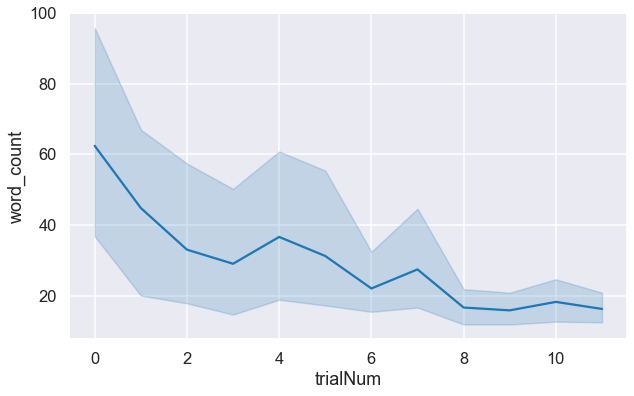

In [37]:
# word count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=trial_sums[~trial_sums.practice], x='trialNum', y='word_count')
#              , hue='gameid')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

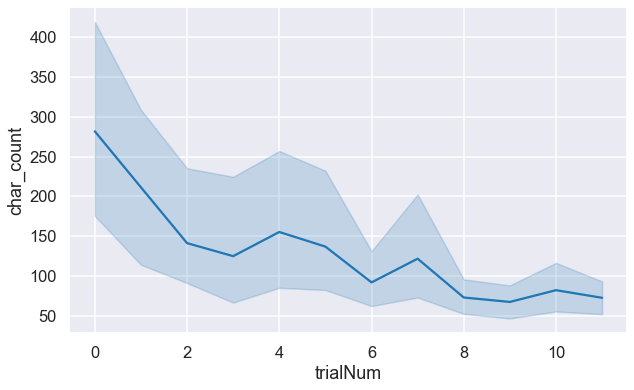

In [38]:
# char count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=trial_sums, x='trialNum', y='char_count')
             #, hue='gameid')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#### Repetition to repetition (of tower pairs?)

/Users/will/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


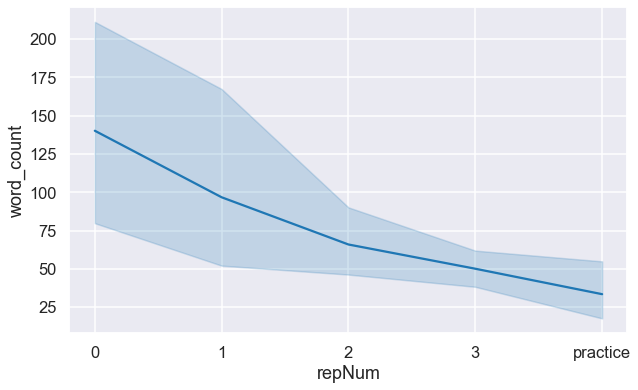

In [39]:
# word count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums[~(rep_sums.practice=='practice')], x='repNum',y='word_count')

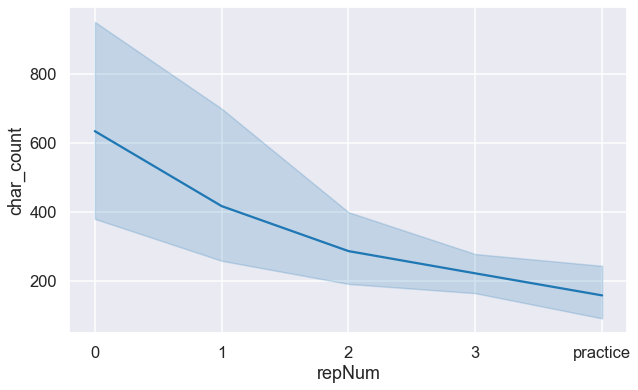

In [40]:
# Char count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='char_count')

In [41]:
# Number of blocks across trials (by game)

plt.figure(figsize=(10,6))
sns.lineplot(data=trial_counts, x='trialNum',y='content')
             #, hue='gameid') 
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# y variable doesn't matter here- it just counts the number of rows in each group

ValueError: Could not interpret input 'content'

<Figure size 720x432 with 0 Axes>

### Accuracy

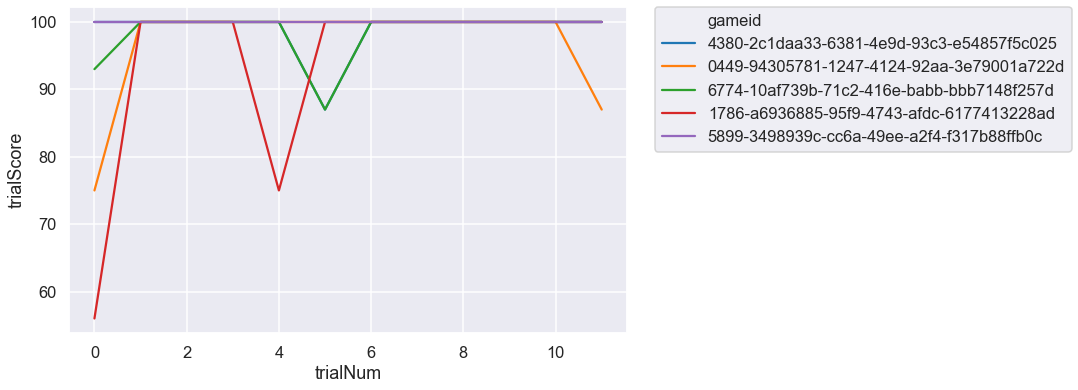

In [42]:
# accuracy across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='trialScore', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

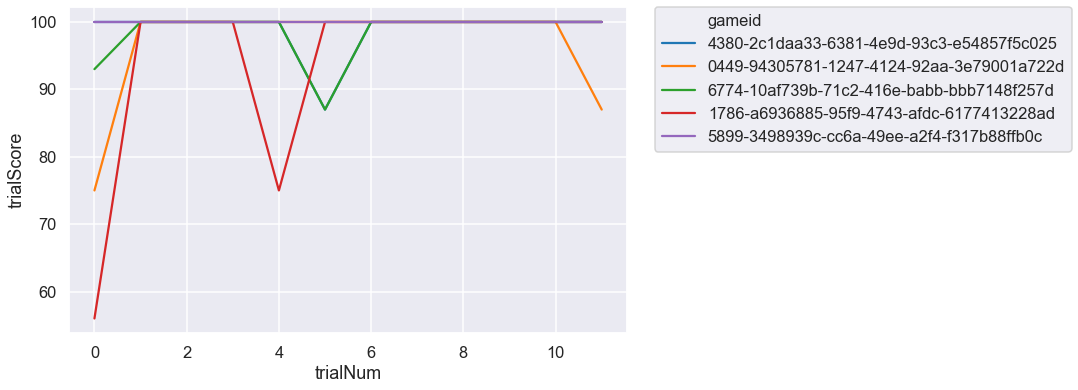

In [43]:
# accuracy across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='trialScore', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

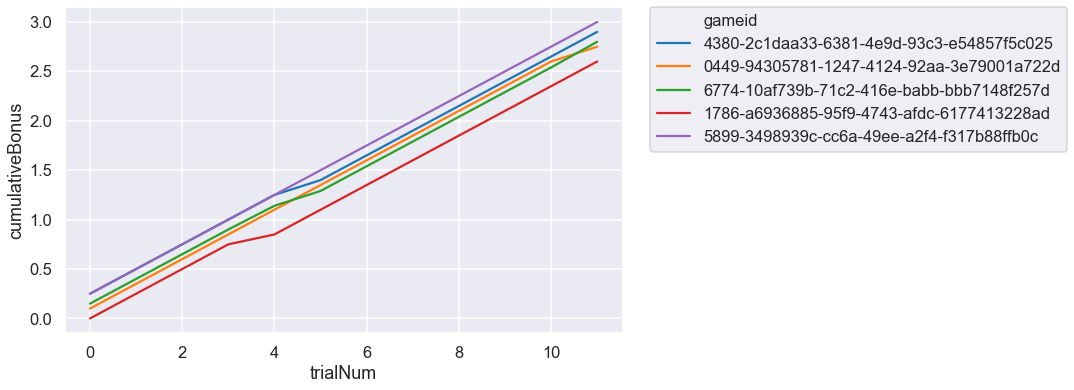

In [44]:
# bonus across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='cumulativeBonus', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

### Timing variables 

#### Create timings dataframe

In [ ]:
df_trial_time = df_block[~df_block.practice].groupby(['gameid','trialNum'])\
                ['timeElapsedInTrial'].max().reset_index()

df_trial_time = df_trial_time.rename(columns = {'timeElapsedInTrial':'time_final_block'})

In [ ]:
chat_times = df_chat[~df_chat.practice].groupby(['gameid','trialNum'])\
['timeElapsedInTurn'].sum().reset_index()


In [ ]:
total_block_times = df_block[(~df_block.practice)].groupby(['gameid','trialNum','turnNum'])\
                    ['timeElapsedInTurn'].max()\
                    .groupby(['gameid','trialNum']).sum().reset_index()

In [ ]:
# time from trial_start to final block placed in turn, summed across the trial
df_trial_time['total_block_duration'] = total_block_times['timeElapsedInTurn'] 

# time from trial_start to chat message sent, summed across the trial
df_trial_time['total_chat_duration'] = chat_times['timeElapsedInTurn']

# sum of block placement and chat time in a trial
df_trial_time['total_duration'] = df_trial_time['total_chat_duration'] + df_trial_time['total_block_duration']

# differnce between final block placement time and total chat plus block placement time.
# i.e. the total extra time in a trial, mainly consisting of time to press done button
df_trial_time['diff'] = df_trial_time['time_final_block'] - df_trial_time['total_duration']

# in addition, add a total_turn_duration- 
#  the time between this turn start and the next turn start (or final block placement)
#  as an estimate for when the Done button is pressed.
# didn't have the data for this in pilot3- we are now saving turnStartTime

df_trial_time

#### Total trial time

In [ ]:
# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='time_final_block')

In [ ]:
# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='time_final_block', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#### Time to send messages

In [ ]:
# total time from start of turn to message sent in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='total_chat_duration')

In [ ]:
# total time from start of turn to message sent in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='total_chat_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#### Time to place blocks

In [ ]:
# total time from start of turn to final block placement in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='total_block_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [ ]:
# total time from start of turn to final block placement in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time[df_trial_time.gameid != '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='total_block_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [ ]:
# total time from start of turn to final block placement in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time[df_trial_time.gameid != '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='total_block_duration')

#### Sum of chat and block time

In [ ]:
# Total time in trial (should be roughly similar to final block time)

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='total_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [ ]:
# max time in trial

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time[df_trial_time.gameid != '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='total_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [ ]:
# max time in trial

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time[df_trial_time.gameid != '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='total_duration')


### Builder: Reconstruction accuracy (intersection over union, IOU) across trials

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['gameid','repNum'])['trialScore'].mean().groupby(['repNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['repNum','gameid'])['trialScore'].mean().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

In [ ]:
df_trial.groupby(['gameid'])['trialScore'].mean().hist()

In [ ]:
#Dist of trial scores:
(df_trial.groupby(['gameid','trialNum']).trialScore.max().hist(bins = 8))
plt.show()


#### Builder: Distribution of blocks placed per utterance


In [ ]:
(df_block.groupby(['gameid','trialNum', 'turnNum'])['_id'].count()).hist(bins = 8)
plt.show()


#### Builder: Total reconstruction time (summed build time across turns, within each trial) across trials

In [ ]:
#check time elapsed
df_block["timeElapsedInTurn"] = pd.to_numeric(df_block['timeElapsedInTurn'])

In [ ]:
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum()

In [ ]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Builder')

In [ ]:
## line plots: time for each builder
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['trialNum','gameid'])['timeElapsedInTurn'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Time elapsed in trial Builder')

In [ ]:
df_block.timeElapsedInTurn.min()

In [ ]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_trial['trialNum'] = pd.to_numeric(df_trial['trialNum'], errors = 'coerce')
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_block['trialNum'] = pd.to_numeric(df_block['trialNum'], errors = 'coerce')

#### Architect: Total typing time (across turns within at trial) across trials

In [ ]:
#check time elapsed
df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

In [ ]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Architect')

In [ ]:
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean()

## Import R plots from RSS 2020

In [ ]:
!conda install rpy2
import rpy2

In [ ]:
import rpy2.rinterface
%load_ext rpy2.ipython


%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)

In [ ]:
ggplot(block_dyad,  aes(x = repNum, y = blocksPlaced))+
  geom_line(aes(group = gameid), alpha = 0.3)+
  geom_line(data =block_grouped, aes(x = repNum, y = blocksPlaced), size = 2, color = 'red')+
  #theme_bw()+
  xlab('Repetition Number')+
  ylab('Number of Blocks per Instruction')

## Explore negative timing data

In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6']

In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time\
    - df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].turnStartTime 

In [ ]:

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='time')
sns.lineplot(data=df_block[df_block.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='turnStartTime')
#sns.lineplot(data=df_chat[df_chat.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='time')

In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time - df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].turnStartTime 



In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time

In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time - 1599071000000

In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].timeElapsedInTurn

# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='timeElapsedInTurn', hue='turnNum')


In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6']

In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].timeElapsedInTurn

# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='trialStartTime', hue='gameid')
sns.lineplot(data=df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='trialStartTime', hue='gameid')


In [ ]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].timeElapsedInTurn

# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='timeElapsedInTurn', hue='turnNum')
sns.lineplot(data=df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='timeElapsedInTurn', hue='turnNum')


In [ ]:
df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time - df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].turnStartTime 



In [ ]:
df_exit[df_exit.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6']